In [102]:
import torch
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.cluster import KMeans
from torch.nn import TripletMarginLoss
import matplotlib.pyplot as plt


### Функция потерь Triplet Loss и Contrastive Loss
L=max(0,d(a,p)−d(a,n)+margin)\
L=y⋅d^2+(1−y)⋅max(0,margin−d)^2



In [103]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = torch.norm(anchor - positive, p=2)
    distance_negative = torch.norm(anchor - negative, p=2)

    loss = torch.max(torch.tensor(0.0), distance_positive - distance_negative + margin)
    return loss

In [104]:
def contrastive_loss(vector1, vector2, label, margin=1.0):
    distance = torch.norm(vector1 - vector2, p=2)

    loss = label * distance**2 + (1 - label) * torch.max(torch.tensor(0.0), margin - distance)**2
    return loss

### Генерация случайных векторов и класеризация

In [105]:
X_random = np.random.randn(100, 2)

X_clusters, y_clusters = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42)
X_clusters = torch.tensor(X_clusters, dtype=torch.float32)
y_clusters = torch.tensor(y_clusters)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_clusters)

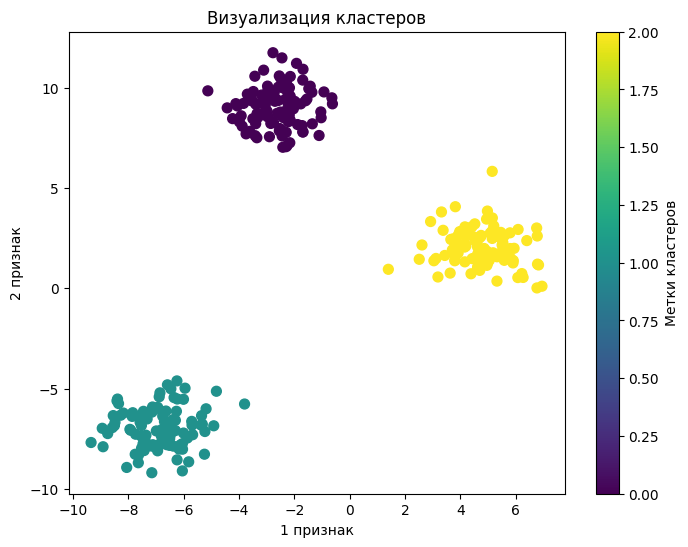

In [106]:
# Визуализация кластеров
plt.figure(figsize=(8, 6))
plt.scatter(X_clusters[:, 0], X_clusters[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Визуализация кластеров')
plt.xlabel('1 признак')
plt.ylabel('2 признак')
plt.colorbar(label='Метки кластеров')
plt.show()

In [107]:
def calculate_triplet_losses(X, y, margin=1.0, num_samples=1000):
    intra_cluster_losses = []
    inter_cluster_losses = []

    for _ in range(num_samples):
        # Выбор случайных индексов
        a_idx, p_idx, n_idx = np.random.choice(len(X), size=3)

        # Проверка, внутри одного кластера
        if y[a_idx] == y[p_idx]:
            loss = triplet_loss(X[a_idx], X[p_idx], X[n_idx], margin).item()
            intra_cluster_losses.append(loss)
        # Между кластерами
        else:
            loss = triplet_loss(X[a_idx], X[p_idx], X[n_idx], margin).item()
            inter_cluster_losses.append(loss)

    return intra_cluster_losses, inter_cluster_losses

intra_triplet_losses, inter_triplet_losses = calculate_triplet_losses(X_clusters, y_clusters, margin=1.0)

In [108]:
def calculate_contrastive_losses(X, y, margin=1.0, num_samples=1000):
    intra_cluster_losses = []
    inter_cluster_losses = []


    for _ in range(num_samples):
        # Выбор случайных индексов
        v1_idx, v2_idx = np.random.choice(len(X), size=2)

        # Проверка, принадлежат ли точки одному кластеру
        label = int(y[v1_idx] == y[v2_idx])
        #print(f'Pair indices: ({v1_idx}, {v2_idx}), Label: {label}')

        loss = contrastive_loss(X[v1_idx], X[v2_idx], torch.tensor(label, dtype=torch.float32), margin).item()

        # Внутри одного кластера
        if label == 1:
            intra_cluster_losses.append(loss)
        # Между кластерами
        else:
            inter_cluster_losses.append(loss)

    return intra_cluster_losses, inter_cluster_losses

intra_contrastive_losses, inter_contrastive_losses = calculate_contrastive_losses(X_clusters, y_clusters, margin=15.0)

### Проверить функции потерь

In [109]:
mean_intra_triplet_loss = round(np.mean(intra_triplet_losses),3)
mean_inter_triplet_loss = round(np.mean(inter_triplet_losses),3)

print(f'Mean Triplet Loss (внутри кластера): {mean_intra_triplet_loss}')
print(f'Mean Triplet Loss (между кластерами): {mean_inter_triplet_loss}')

Mean Triplet Loss (внутри кластера): 0.336
Mean Triplet Loss (между кластерами): 5.21


In [110]:
mean_intra_contrastive_loss = round(np.mean(intra_contrastive_losses),3)
mean_inter_contrastive_loss = round(np.mean(inter_contrastive_losses),3)

print(f'Mean Contrastive Loss (внутри кластера): {mean_intra_contrastive_loss}')
print(f'Mean Contrastive Loss (между кластерами): {mean_inter_contrastive_loss}')

Mean Contrastive Loss (внутри кластера): 3.532
Mean Contrastive Loss (между кластерами): 8.8


### Выводы:
1. Triplet Loss
Значения Triplet Loss внутри одного кластера значительно меньше, чем между кластерами. Это соответствует ожидаемому поведению.
Функция минимизирует расстояние между "якорем" и "положительным примером" (внутри одного кластера).
Одновременно она максимизирует расстояние между "якорем" и "отрицательным примером" (между кластерами).
Разница в значениях показывает, что функция успешно разделяет кластеры.
2. Contrastive Loss
Значения Contrastive Loss внутри одного кластера меньше, чем между кластерами. Это также соответствует ожидаемому поведению.
Для пар из одного кластера функция минимизирует расстояние, что приводит к меньшим значениям потерь.
Для пар из разных кластеров функция максимизирует расстояние, что приводит к большим значениям потерь.
Разница в значениях подтверждает, что функция успешно разделяет кластеры.